In [9]:

from argparse import Namespace
from torch.utils.data import DataLoader

from datasets import *
from scenario import *
from models import *
from method import *
from scenario.evaluators import *

from utils import seedEverything, AverageMeter
import progressbar

In [10]:
# args
args = Namespace()
class Config:
    batch_size = 128
    lr = 0.01
    nowand = 1
    n_epochs = 3
    debug = 1
    save_path = 'save/cifar10'
    save_model = 1

args = Config

In [11]:
# seed
seedEverything(0)

In [12]:
# scenario
splitcifar10 = SplitCIFAR10(root='./data')
paircifar10 = PairCIFAR10(root='./data')

train_scenario = ClassIncremental(
        dataset=splitcifar10, n_tasks=splitcifar10._DEFAULT_N_TASKS, batch_size=32, n_workers=0
    )
test_scenario = VerificationScenario(
    dataset=paircifar10, n_tasks=paircifar10._DEFAULT_N_TASKS, batch_size=32, n_workers=0
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Seed is not fixed, initialize indices!
Completed (query index, retrieval index) shape : (5000, 5000)


In [13]:
n_classes = splitcifar10.n_classes()
args.N_CLASSES_PER_TASK = splitcifar10._N_CLASSES_PER_TASK
args._DEFAULT_N_TASKS = splitcifar10._DEFAULT_N_TASKS

In [14]:
# model
net = resnet18(n_classes)
loss = torch.nn.CrossEntropyLoss()
method = LwF(net, loss, args, None)

In [15]:
# logger (wandb & local & tensorboard)
# def set_loggers()
#     raise NotImplementedError

In [8]:
# train

# 1. before train : set loggers
# set_loggers()

# 2. train
def train(task_id, train_loader, n_epochs=10):
    #- Start Epoch
    scheduler = None
    for epoch in range(n_epochs):
        #-- Start Iteration
        losses = AverageMeter()
        for idx, (inputs, labels, task, not_aug_inputs) in enumerate(train_loader):
            inputs, labels, not_aug_inputs = inputs.to(device), labels.to(device), not_aug_inputs.to(device)

            if hasattr(method, 'meta_observe'):
                loss = method.meta_observe(inputs, labels, not_aug_inputs)
            else:
                loss = method.observe(inputs, labels, not_aug_inputs)
            losses.update(loss, inputs.size(0))
        
        if scheduler is not None:
            scheduler.step()
        

        

In [18]:
n_epochs = 50

In [24]:
method.net.to(method.device)

for task_id, train_loader in enumerate(train_scenario):
    #- Start Epoch
    scheduler = None
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        #-- Start Iteration
        losses = AverageMeter()
        for idx, (inputs, labels, task, not_aug_inputs) in enumerate(train_loader):
            if idx > 100:
                break
            inputs, labels, not_aug_inputs = inputs.to(method.device), labels.to(method.device), not_aug_inputs.to(method.device)

            if hasattr(method, 'meta_observe'):
                loss = method.meta_observe(inputs, labels, not_aug_inputs)
            else:
                loss = method.observe(inputs, labels, not_aug_inputs)
            losses.update(loss, inputs.size(0))
        
        if scheduler is not None:
            scheduler.step()
            
        pbar.set_description(f"[Task:{task_id}|Epoch:{epoch}] Avg Loss: {losses.avg:.5}")
    break

[Task:0|Epoch:49] Avg Loss: 0.0053149: 100%|██████████| 50/50 [01:42<00:00,  2.06s/it]


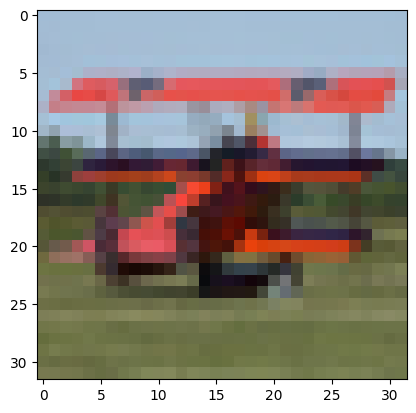

In [ ]:
# visualize inputs
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(inputs[1])

In [10]:
cifar10_verif_evaluator = VerificationEvaluator(method=method, eval_scenario=test_scenario, name="Verification")

In [11]:
accs = cifar10_verif_evaluator.fit(current_task_id=1, logger=None)


Representation | Observed Verification-Acc: 53.88 | Observed Verification-Auc: 54.47 |


In [ ]:
accs

56.64

In [29]:
state_dict = torch.load("save/cifar10/lwf_1.pth")

method.net.load_state_dict(state_dict)

<All keys matched successfully>